# Import libraries

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, matplotlib.cm as cm
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
from geopy.distance import great_circle
from pymongo import MongoClient
import calendar

import geopandas as gpd
from shapely.geometry import Point
import time

# setup database

In [2]:
client = MongoClient('localhost', 27017)
db = client['promed']
posts = db.posts

# setup map

In [3]:
# Use shapefile bundled with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.crs

{'init': u'epsg:4326'}

# Functions

In [4]:
# Gets a unique list of diseases
def get_disease_list():
#   diseaseNames = posts.distinct('subject.diseaseLabels')
#   return sorted(diseaseNames)
    return ['Anthrax']

In [5]:
# Get all the articles that have the current disease in it's "diseaseLabels" array
def get_articles(disease):
#   print('get articles', disease)
  articles = posts.find({ 
    'zoomLat': {'$ne': None}, 
    'zoomLon': {'$ne': None}, 
    'subject.diseaseLabels':{'$not':{'$size': 0}}, 
    'subject.diseaseLabels': {'$in': [disease]}
    },
    {'subject.diseaseLabels':1,
    'zoomLat': 1, 
    'zoomLon': 1, 
    'sourceDate': 1, 
    'promedDate': 1}
  ).limit(3000)
  articles = list(articles);
  for article in articles:
    try:
        # not all articles have a sourceDate so fall back to promedDate if missing.
        date = article.get('sourceDate') or article.get('promedDate')
        # convert date object to timestamp so DBSCAN can handle it
        article['sourceDate'] = calendar.timegm(date.timetuple())/10000000.0
        # convert disease labels array to single disease name
        article['subject'] = article['subject']['diseaseLabels'][0]
        article['zoomLat'] = float(article['zoomLat'])
        article['zoomLon'] = float(article['zoomLon'])
    except Exception as e:
        print("Problem parsing article:", article)
        print(e)
        raise
#   print(sorted([x['sourceDate'] for x in articles]))

  return articles

### Mapping Functions

In [6]:
def get_points_projection(df):
    # create a new geopandas geodataframe from the point data
    points = gpd.GeoDataFrame(df)
     # create a geometry column in our point data set for geopandas to use
    points['geometry'] = points.apply(lambda item: Point(item['zoomLon'], item['zoomLat']), axis=1)
    points.crs = world.crs
    return points

def project_map(pointList):
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    world.plot(ax=ax, color='white', edgecolor='#cccccc')
    
#     Sort by length of cluster
    pointList.sort(lambda x,y: cmp(len(x), len(y)))
    
#     Colormaps: http://matplotlib.org/users/colormaps.html
    cmap = cm.get_cmap('plasma')
    for points in pointList:
        color = cmap(len(points)/float(7))
        points.plot(ax=ax, marker='o', color=color, markersize=5)
    plt.show()

# Single step clustering on timestamp/lat/long

### Questions:
How do I determine the optimal `eps` value here?

How should I take into account the third dimension (timestamp) when determining the `eps` value?  When it was only lat long the values were in similar ranges (-90 -> 90 and -180 -> 180) but with the timestamp values are much larger (ex: `9433152000`) which makes me thing that you will never get two timestamps in the same neighborhood if you have and eps value of, say, 2.  If I begin dividing the timestamp value by 10,000,000 it goes into a similar range for lat/long - is this something I should consider doing?

Is it possible to specify dimensions for a sphereoid to define the `eps`?  It seems like there are a lot of situations where you wouldn't want a perfectly simetrical shape defining the neighborhood.

How would I go about visualizing 3d data?  4d?


In [7]:
def cluster(data, fields, eps=2):
#     print(type(data))
    if type(data) is not np.ndarray:
#         print('convert....')
        data = data.as_matrix(columns=fields)
#     print(type(data))
    #   coordinates = df.as_matrix(columns=['zoomLon', 'zoomLat'])
    dbsc = DBSCAN(eps=eps, min_samples=1, algorithm='ball_tree').fit(data)
    core_samples_mask = np.zeros_like(dbsc.labels_, dtype=bool)
    core_samples_mask[dbsc.core_sample_indices_] = True
    cluster_labels = dbsc.labels_
    num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    clusters = pd.Series([data[cluster_labels == n] for n in range(num_clusters)])
#     print('Number of clusters: {}'.format(num_clusters))
#     for cluster in clusters:
#         print(cluster[:])
#     print('***********')
    return clusters

In [8]:
def distance_cluster(data, fields):
    kms_per_radian = 6371.0088
    eps = 1.5 / kms_per_radian
#     print("distance data:")
#     print(np.radians(data[fields]))
    dbsc = DBSCAN(eps=eps, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(data[fields]))
    core_samples_mask = np.zeros_like(dbsc.labels_, dtype=bool)
    core_samples_mask[dbsc.core_sample_indices_] = True
    cluster_labels = dbsc.labels_
    num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    clusters = pd.Series([data[cluster_labels == n] for n in range(num_clusters)])
    return clusters

In [9]:
def cluster_single_step(df):
    cluster(df,['zoomLon', 'zoomLat', 'sourceDate'])

# Two step temporal/spatial clustering
First cluster on times only.  After that cluster on lat/long great circle distances

In [10]:
def cluster_two_step(df):
    # perform temporal clustering
    temporalClusters = cluster(df,['sourceDate'], .1) # eps of .1 ~ 8 days

    allClusterPoints = []
    for temporalCluster in temporalClusters:
        subSet = df['sourceDate'].isin(temporalCluster.flatten())
        clusterArticles = df.loc[subSet][['sourceDate','zoomLat','zoomLon']]

#         perform clustering on the articles in that cluster based on the lat/long great circle distance
        spacialTemporalClusters = distance_cluster(clusterArticles, ['zoomLat', 'zoomLon'])

#         record point data for the cluster
        pointList = []
        for spacialCluster in spacialTemporalClusters:
            clusterPoints = get_points_projection(spacialCluster)
            pointList.append(clusterPoints)
            allClusterPoints.append(clusterPoints)
        
#         Project to map and print columns
        project_map(pointList)
        for spacialCluster in spacialTemporalClusters:
            print(spacialCluster[['sourceDate','zoomLat','zoomLon']])

#     Project all layers into a map. Warning: heavy.
#     print('\n\n')
#     print("--------------------------------------------------------------------------------")
#     print("--- All recorded points --------------------------------------------------------")
#     print("--------------------------------------------------------------------------------")
#     project_map(allClusterPoints)

# Process articles

--------------------------------------------------------------------------------
2183 articles for Anthrax


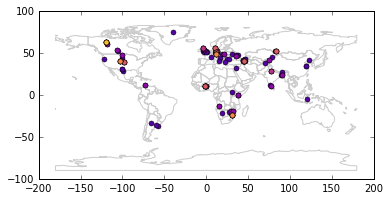

c:\python27\lib\site-packages\ipykernel\__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [11]:
diseaseList = get_disease_list()
# for each disease get a list of articles and cluster them
df = []
startTime = time.time()
for disease in diseaseList:
    articleList = list(get_articles(disease))
    print("--------------------------------------------------------------------------------")
    print("{0} articles for {1}".format(len(articleList), disease))
    df = pd.DataFrame(articleList)
#     cluster_single_step(df)
    cluster_two_step(df)

print("--- FINISHED -------------------------------------------------------------------")
print("Total run time: {0}ms".format(time.time() - startTime))

# Questions:
What would be the next steps?  How do we determine which cluster future articles fall into?  Do I just re-run this with all the data?